In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import sinh, cosh

In [2]:
# Initial matrixes A x = f:
# a -> A
# b -> f

matrix_a = [
    [4.0, 1.0, 0.0, 0.0],
    [1.0, 4.0, 1.0, 0.0],
    [0.0, 1.0, 4.0, 1.0],
    [0.0, 0.0, 1.0, 4.0]
]
matrix_a = np.array(matrix_a)

In [3]:
matrix_b = [6.0, 12.0, 18.0, 19.0]
matrix_b = np.array(matrix_b)

In [4]:
# The solution using the python function
np.linalg.solve(matrix_a, matrix_b)

array([1., 2., 3., 4.])

In [5]:
# Function to find the coefficients of a linear system of the form A x = f.
# Where A is a tridiagonal matrix, f is a vector with the function values,
# and x is a vector which we want to find its components to solve the system.

def solution_coefficients(matrix_A, vector_f):
    matrix = matrix_A.copy()
    vector = vector_f.copy()
    
    for i in range(1, np.shape(matrix)[0]):
        vector[i] = vector[i] - (matrix[i, i-1] / matrix[i-1, i-1]) * vector[i-1]
        matrix[i] = matrix[i] - (matrix[i, i-1] / matrix[i-1, i-1]) * matrix[i-1]
    
    coefficients = np.array([vector[-1] / matrix[-1, -1]])
    
    for i in range(np.shape(matrix)[0] - 2, -1, -1):
        x = (vector[i] - matrix[i, i+1] * coefficients[0]) / matrix[i, i]
        coefficients = np.insert(coefficients, 0, x)
        
    return coefficients

In [6]:
# The order of the coefficients is as follows:
# sol = {sol_0, sol_1, sol_2, ... , sol_n}

solution_coefficients(matrix_a, matrix_b)

array([1., 2., 3., 4.])

In [7]:
nodes_x = [0.0, 1.0, 1.8, 5.1, 8.3, 9.7, 11.0, 14.5, 18.0, 19.2, 20.4, 23.6, 25.0]
nodes_y = [1.3, 1.35, 2.9, 3.4, 3.8, 5.6, 7.2, 7.2, 7.2, 5.9, 4.6, 4.6, 0.0]
tau_values = [0.25, 4.0, 10.0]

In [8]:
def h(i, x_nodes):
    return x_nodes[i+1] - x_nodes[i]

In [9]:
def alpha(i, tau, x_nodes):
    return (1 / h(i, x_nodes)) - (tau / sinh(tau * h(i, x_nodes)))

In [10]:
def beta(i, tau, x_nodes):
    return (tau * cosh(tau * h(i, x_nodes)) / sinh(tau * h(i, x_nodes))) - (1 / h(i, x_nodes))

In [11]:
def gamma(i, tau, x_nodes, y_nodes):
    return tau**2 * (y_nodes[i+1] - y_nodes[i]) / h(i, x_nodes)

In [12]:
# The form of the system of equations is:
# alpha(i-1) z(i-1) + (beta(i-1) + beta(i)) z(i) + alpha(i) z(i+1) = gamma(i) - gamma(i-1)
# The system of equations depends on the length of the set of nodes/knots
def coefficients(tau, x_nodes, y_nodes):
    matrix_alpha_beta = np.zeros((len(x_nodes) - 2, len(x_nodes)))
    column_vector_gamma = np.zeros(len(x_nodes) - 2)
    
    # Generatingthe system of equations by row
    for i in range(1, len(x_nodes) - 1):
        matrix_alpha_beta[i - 1, i - 1] = alpha(i - 1, tau, x_nodes)
        matrix_alpha_beta[i - 1, i] = (beta(i - 1, tau, x_nodes) + beta(i, tau, x_nodes))
        matrix_alpha_beta[i - 1, i + 1] = alpha(i, tau, x_nodes)
        
        column_vector_gamma[i - 1] = (gamma(i, tau, x_nodes, y_nodes) - gamma(i - 1, tau, x_nodes, y_nodes))
        
    matrix_alpha_beta = matrix_alpha_beta[:,1:-1]
        
    coefficients_z = solution_coefficients(matrix_alpha_beta, column_vector_gamma)
    coefficients_z = np.insert(coefficients_z, 0, 0)
    coefficients_z = np.append(coefficients_z, 0)
    
    return coefficients_z

In [13]:
def interpolation_function(i, x, tau, x_nodes, y_nodes):
    coeff = coefficients(tau, x_nodes, y_nodes)
    
    solution = ((coeff[i] * sinh(tau * (x_nodes[i+1] - x))
                + coeff[i+1] * sinh(tau * (x - x_nodes[i]))) / (tau**2 * sinh(tau * h(i, x_nodes))) 
                + (y_nodes[i] - coeff[i] / tau**2) * (x_nodes[i+1] - x) / h(i, x_nodes) 
                + (y_nodes[i+1] - coeff[i+1] / tau**2) * (x - x_nodes[i]) / h(i, x_nodes))
    
    return solution

In [14]:
def interval(i, delta_x, tau, x_nodes, y_nodes):
    # Condition to include the last node in the last interval, because the arange
    # function does not include the last value the specified interval.
    k = 0
    if i == len(x_nodes) - 2:
        k = delta_x
        
    interval_x = np.arange(x_nodes[i], x_nodes[i+1] + k, delta_x)
    interpolated_y_values = interpolation_function(i, interval_x, tau, x_nodes, y_nodes)
    
    return interval_x, interpolated_y_values;

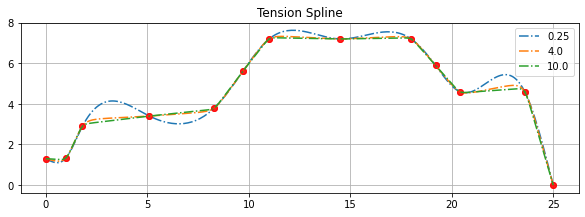

In [45]:
plt.figure(figsize=(10,10))

for tau in tau_values:    
    x_set = np.array([])
    y_set = np.array([])

    for i in range(0, len(nodes_x)-1):
        x_vals, y_vals = interval(i, 0.1, tau, nodes_x, nodes_y)
        x_set = np.append(x_set, x_vals)
        y_set = np.append(y_set, y_vals)

    plt.plot(nodes_x, nodes_y, 'o', color='red', alpha=0.5)
    plt.plot(x_set, y_set, '-.', label=tau)
    plt.title('Tension Spline')
    plt.axis('scaled')
    
plt.legend(loc='best')
plt.grid()
